# Tutorial: Create a STEPS Nowcast using HSAF

In this notebook, we will create a nowcast. The processing steps build upon the work from the first notebook, where HSAF-H60B data was downloaded and preprocessed. 
The 'processed' folder containing the pre-processed files will be used as input for the nowcast.

To create a nowcast, we will use the pysteps library and the nowcast script, available in the EnhancedStepsNowcast.py

In this tutorial we are going to:
1. Load preprocessed HSAF files
2. Select a region of interest
3. Run the nowcast 
4. Visualize and export the nowcast results

In [46]:
# Here, we load the required libraries.
import glob
import xarray as xr
import numpy as np
from pathlib import Path
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
from datetime import datetime, timedelta, date
import pandas as pd
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import cartopy.crs as ccrs
from pathlib import Path
import math
import matplotlib.colors as mcolors

# Load the nowcast function and the PySTEPS package
from enhanced_steps import EnhancedStepsNowcast
print("All libraries have been successfully imported!")

All libraries have been successfully imported!


# Step 1: Define the data folder structure

In [47]:
# Create folders for our data
data_folder = Path("./h60b_data")
processed_folder = data_folder / "processed"        # This is the folder where, in the preprocessing script, the processed precipitation files were saved.
nowcasting_folder = data_folder / "nowcast"

# Create the folder for forecasts
Path(nowcasting_folder).mkdir(parents=True, exist_ok=True)

# Step 2: Define the nowcast parameters

In [48]:
settings = {
    "data_source": "h60b",     # Data source
    "ensemble": 5,             # Number of ensemble members
    "n_input_files": 10,       # Number of input files used
    "n_lead_times": 12,        # Number of lead times to forecast, each time step is 15 minutes
    "frequency": 15,           # Minutes between each time step
    "transform": "dB",         # Transformation used by pysteps ("dB", "log", ...)
    "threshold": 0.05,         # Threshold (mm/h) to define rain / no rain
    "buffer_distance": 5000,   # Distance in meters around a region of interest for cropping of the rainfall data
    "crs_out": "EPSG:4326",    # Output coordinate reference system
    "norain_thr": 0.005,       # Parameters for the Norain method
    "zerovalue": -15.0,        # Parameters for the Norain method
    "max_workers": 2,          # Number of processors to use
}

# Step 3: Search for downloaded and preprocessed HSAF files

In [49]:
# --- List of all available files ---
all_files = sorted(processed_folder.glob("*H60B*.nc"))
print("Available HSAF files in the processed folder:")
for i, f in enumerate(all_files):
    print(f"{i}: {f.name}")

Available HSAF files in the processed folder:
0: HSAF-H60B_20250810T080000.nc
1: HSAF-H60B_20250810T081500.nc
2: HSAF-H60B_20250810T083000.nc
3: HSAF-H60B_20250810T084500.nc
4: HSAF-H60B_20250810T090000.nc
5: HSAF-H60B_20250810T091500.nc
6: HSAF-H60B_20250810T093000.nc
7: HSAF-H60B_20250810T094500.nc
8: HSAF-H60B_20250810T100000.nc
9: HSAF-H60B_20250810T101500.nc
10: HSAF-H60B_20250810T131500.nc
11: HSAF-H60B_20250810T133000.nc
12: HSAF-H60B_20250810T134500.nc
13: HSAF-H60B_20250810T140000.nc
14: HSAF-H60B_20250810T141500.nc
15: HSAF-H60B_20250810T143000.nc
16: HSAF-H60B_20250810T144500.nc
17: HSAF-H60B_20250810T150000.nc
18: HSAF-H60B_20250810T151500.nc
19: HSAF-H60B_20250810T153000.nc
20: HSAF-H60B_20250826T124500.nc
21: HSAF-H60B_20250826T130000.nc
22: HSAF-H60B_20250826T131500.nc
23: HSAF-H60B_20250826T133000.nc
24: HSAF-H60B_20250826T134500.nc
25: HSAF-H60B_20250826T140000.nc
26: HSAF-H60B_20250826T141500.nc
27: HSAF-H60B_20250826T143000.nc
28: HSAF-H60B_20250826T144500.nc
29: HSA

In [50]:
def find_latest_inputs(processed_folder, n=10, start_file=None):
    """
    Retrieve preprocessed HSAF files for the nowcast.
    """
    # List all H60B files and sort
    all_files = sorted(processed_folder.glob("*H60B*.nc"))
    
    if start_file is None:
        # Standard mode: take the last n files
        return list(reversed(all_files))[:n]
    else:
        # Start_file mode: find the index of the starting file
        start_file = Path(start_file).name  # only the name
        indices = [i for i, f in enumerate(all_files) if f.name == start_file]
        if not indices:
            raise ValueError(f"The start file '{start_file}' was not found in the folder.")
        start_idx = indices[0]
        # Return n files starting from start_idx
        return all_files[start_idx:start_idx + n]

# Mode 1: latest files
# input_files = find_latest_inputs(processed_folder, n=10)

# Mode 2: starting from a specific file
start_file = processed_folder / "HSAF-H60B_20250830T124500.nc"
input_files = find_latest_inputs(processed_folder, n=10, start_file=start_file)

input_files

[PosixPath('h60b_data/processed/HSAF-H60B_20250830T124500.nc'),
 PosixPath('h60b_data/processed/HSAF-H60B_20250830T130000.nc'),
 PosixPath('h60b_data/processed/HSAF-H60B_20250830T131500.nc'),
 PosixPath('h60b_data/processed/HSAF-H60B_20250830T133000.nc'),
 PosixPath('h60b_data/processed/HSAF-H60B_20250830T134500.nc'),
 PosixPath('h60b_data/processed/HSAF-H60B_20250830T140000.nc'),
 PosixPath('h60b_data/processed/HSAF-H60B_20250830T141500.nc'),
 PosixPath('h60b_data/processed/HSAF-H60B_20250830T143000.nc'),
 PosixPath('h60b_data/processed/HSAF-H60B_20250830T144500.nc'),
 PosixPath('h60b_data/processed/HSAF-H60B_20250830T150000.nc')]

# Step 4: Load input files for the nowcast
The different data layers correspond to different time steps, we are going to combine this timesteps into a single 3D dataset: x (longitude), y (latitude), and time.
Afterwards, this single dataset can be used as input for our nowcast.


In [51]:
def open_as_time_stack(input_files):
    """
    This function opens the selected preprocessed HSAF files and combines them
    into a single xarray Dataset with the 'time' dimension.
    """
    if not input_files:
        raise FileNotFoundError("No input files found.")   # Check that files exist
    datasets = xr.open_mfdataset(input_files)              # Open and combine all files
    return datasets

# Load the selected files and create a Dataset with the time dimension
input_dataset = open_as_time_stack(input_files)

# Display the Dataset to verify its contents
display(input_dataset)

<xarray.Dataset> Size: 549MB
Dimensions:           (time: 10, y: 3537, x: 3879)
Coordinates:
  * x                 (x) float64 31kB -81.26 -81.22 -81.18 ... 81.22 81.26
  * y                 (y) float64 28kB 74.16 74.12 74.07 ... -73.99 -74.03
  * time              (time) datetime64[ns] 80B 2025-08-30T12:45:00 ... 2025-...
    spatial_ref       int64 8B 0
Data variables:
    precip_intensity  (time, y, x) float32 549MB dask.array<chunksize=(1, 1769, 1940), meta=np.ndarray>
Attributes: (12/14)
    Conventions:          CF-1.6
    title:                RAINSAT H60B MSG SEVIRI Precipitation
    source:               EUMETSAT H-SAF H60B
    creator:              HKV services
    creation_date:        2025-10-10
    time_coverage_start:  2025-08-30T12:45:00
    ...                   ...
    geospatial_lat_max:   74.15732491263329
    geospatial_lon_min:   -81.25955346826284
    geospatial_lon_max:   81.26224267728661
    crs:                  EPSG:4326
    product_details:      https://hsaf.meteoam.it/Products/Detail?prod=H60B
    data_source:          hsaf-h60b

## What do you see in the display input dataset? 
Dimensions (time, y, x)
- time: the number of time steps included, each time step represents 15 minutes.
- y and x: the spatial grid of the data, with y representing latitude and x representing longitude.

Coordinates
- x: the longitudes of each pixel
- y: the latitudes of each pixel
- time: the exact dates and times for each time step

Data variables (precip_intensity)
- Contains precipitation values in mm/h for each pixel and each time step.

The variable is stored as float32 to save memory space.

Attributes
- General information about the product, such as the source (EUMETSAT H-SAF H60B), 
  the coordinate reference system (EPSG:4326), and the geographical boundaries.

# Step 5: Create an engine for the nowcast model

In [52]:
# Create the engine parameters from the settings defined in Step 2
steps_settings = {
    "datafolder": data_folder,                      # Folder containing the preprocessed HSAF files
    "ensemble": settings["ensemble"],               # Number of ensemble members
    "n_lead_times": settings["n_lead_times"],       # Number of forecast lead times
    "frequency": settings["frequency"],             # Frequency between each time step (minutes)
    "transform": settings["transform"],             # PySTEPS transformation ("dB", "log", etc.)
    "threshold": settings["threshold"],             # Threshold to distinguish rain / no rain
    "buffer_distance": settings["buffer_distance"], # Buffer around the area of interest
    "crs_out": settings["crs_out"],                 # Output coordinate reference system
    "norain_thr": settings["norain_thr"],           # Parameter for "no rain" method
    "zerovalue": settings["zerovalue"],             # Minimum value for "no rain"
    "max_workers": settings["max_workers"],         # Number of CPUs to use
}

# Create the nowcast engine object using the parameters above
engine = EnhancedStepsNowcast(steps_settings, "h60b")


# Step 6: Select the area of interest and inspect the input data for the nowcast

/tmp/ipykernel_1971/3499312275.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


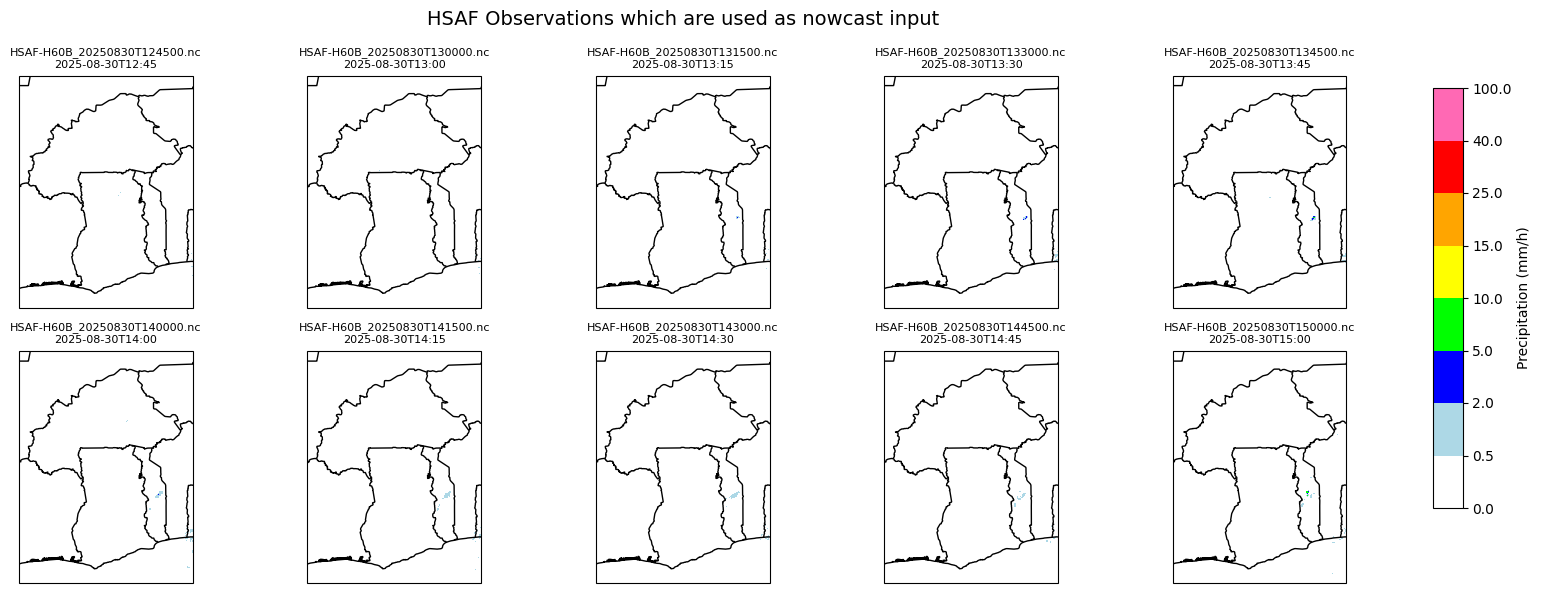

In [53]:
# Select here your area of interest 
region = {"lat_min": 4, "lat_max": 16, "lon_min": -6, "lon_max": 3}

# Define custom bounds and colors for precipitation 
bounds = [0, 0.5, 2, 5, 10, 15, 25, 40, 100]  # intensity bounds
colors = ["#ffffff", "#add8e6", "#0000ff", "#00ff00",
          "#ffff00", "#ffa500", "#ff0000", "#ff69b4"]  # associated colors
cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries=bounds, ncolors=cmap.N)

# Subplots configuration 
max_per_row = 5                             # maximum subplots per row
n_files = len(input_files)
n_rows = math.ceil(n_files / max_per_row)   # number of rows needed

# Create figure with small subplots
fig_width = max_per_row * 3
fig_height = n_rows * 3
fig, axes = plt.subplots(n_rows, max_per_row, figsize=(fig_width, fig_height),
                         subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()  

# Loop over each file to create a subplot
for i, f in enumerate(input_files):
    ds = xr.open_dataset(f)
    
    # Select region and first timestep
    data = ds.sel(
        x=slice(region["lon_min"], region["lon_max"]),
        y=slice(region["lat_max"], region["lat_min"])  # note reversed coordinates
    ).precip_intensity.isel(time=0)
    
    # Mask non-precipitation areas
    data_masked = data.where(data > 0)
    
    ax = axes[i]
    ax.set_extent([region["lon_min"], region["lon_max"], region["lat_min"], region["lat_max"]])
    ax.coastlines(resolution='10m', color='black')
    ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
    
    # Plot precipitation
    im = ax.pcolormesh(
        data_masked["x"], data_masked["y"], data_masked,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        norm=norm
    )
    
    # Add title for each subplot with filename and timestamp
    timestamp_str = str(data.time.values)[:16]
    ax.set_title(f"{f.name}\n{timestamp_str}", fontsize=8)

# Remove empty subplots
for j in range(i+1, n_rows*max_per_row):
    fig.delaxes(axes[j])

# Add a vertical colorbar to the right of all subplots
cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])  
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical', label="Precipitation (mm/h)")

fig.suptitle("HSAF Observations which are used as nowcast input", fontsize=14)
plt.tight_layout()
plt.show()

# Step 7: Run the STEPS nowcast model with Pysteps
This command runs the STEPS nowcast model using on the observation data and the area of interest you defined earlier.
Nowcast parameters (number of lead times, frequency, number of ensembles, thresholds, etc.) are taken from the settings defined in Step 2.

In [54]:
dataset_roi = input_dataset.sel(
    x=slice(region["lon_min"], region["lon_max"]),
    y=slice(region["lat_max"], region["lat_min"])  # note the reversed coordinates
)

nowcast_arrays, metadata = engine.nowcast_steps_pysteps(dataset_roi)

Rain fraction is: 0.008419090835426626, while minimum fraction is 0.005


PermissionError: [Errno 13] Permission denied: '/workspaces/Tools-for-weather-and-climate-services-in-Africa/2_H60B_Nowcast/h60b_data/nowcast/pysteps_h60b_latest.nc'

# Step 8: Export the results to a NetCDF file. 
A NetCDF (Network Common Data Form) file is a format used to store multidimensional data, such as precipitation on a spatial and temporal grid. 
It allows storing information about coordinates (latitude, longitude, time), variables (here precipitation intensity), and metadata.

In [ ]:
output_path = "/workspaces/Tools-for-weather-and-climate-services-in-Africa/2_H60B_Nowcast/h60b_data/nowcast"
Path(output_path).mkdir(parents=True, exist_ok=True)
engine.settings["threddsdata"] = output_path 

engine.export_nowcast_to_netcdf(
    country="Country",
    nowcasting_arrays=nowcast_arrays,
    date_start=None,  
    metadata=metadata,
    reproject=True,
    data_source=settings["data_source"],
)

# Step 9: Inspect and visualize the nowcast results

In [ ]:
# Open the NetCDF file containing the nowcast results
ds = xr.open_dataset(nowcasting_folder / "pysteps_h60b_latest.nc")

# Display some information about the NetCDF file
print("NetCDF file dimensions:", ds.dims)
print("Available variables:", list(ds.data_vars))
print("Coordinates:", list(ds.coords))
print("Attributes:", ds.attrs)

### Visualize a single timestep from the nowcast

In [ ]:
# Load the Nowcast HSAF dataset
ds = xr.open_dataset(nowcasting_folder / "pysteps_h60b_latest.nc")

# Each timestep corresponds to 15 minutes into the future
time_index = 1
data_plot = ds.isel(ens_number=0).precip_intensity.isel(time=time_index)

# Mask areas with no precipitation (0 mm/h)
data_plot_masked = data_plot.where(data_plot > 0)

# Define custom bounds and colors for the map
bounds = [0, 0.5, 2, 5, 10, 15, 25, 40, 100]  # Rain intensity bounds (mm/h)
colors = ["#ffffff", "#add8e6", "#0000ff", "#00ff00",
          "#ffff00", "#ffa500", "#ff0000", "#ff69b4"]  # Colors for each interval
cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries=bounds, ncolors=cmap.N)

# Flip only the precipitation data along the y-axis
# This corrects the rain orientation while leaving the base map intact
data_flipped = data_plot_masked.values[::-1, :]

# Create the figure and set the projection
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([ds.x.min(), ds.x.max(), ds.y.min(), ds.y.max()], crs=ccrs.PlateCarree())

# Add the base map
ax.coastlines(resolution='10m', color='black')                      # Add Coastlines to map
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')  # Add Country borders to map

# Plot the flipped precipitation data
im = ax.pcolormesh(
    ds.x, ds.y, data_flipped,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    norm=norm
)

# Add the colorbar
cbar = plt.colorbar(im, ax=ax, boundaries=bounds, ticks=bounds, label="Precipitation (mm/h)")

# Add the title with the timestep timestamp
time_str = pd.to_datetime(ds.time.isel(time=time_index).values).strftime("%Y-%m-%d %H:%M")
plt.title(f"Nowcast HSAF - Timestep {time_index}: {time_str}")

# Display the figure
plt.show()

### Create a video from the nowcast images

In [ ]:
# Load the Nowcast dataset
ds = xr.open_dataset(nowcasting_folder / "pysteps_h60b_latest.nc")

# Choose the precipitation variable
varname = "precip_intensity" if "precip_intensity" in ds.data_vars else "precipitation"
var = ds[varname]

# Select the first ensemble member if present
if "ens_number" in var.dims:
    var = var.isel(ens_number=0)

# Function to format titles with date and time
def fmt_time(tarr, i):
    v = tarr.isel(time=i).values
    try:
        return np.datetime_as_string(np.asarray(v, dtype="datetime64[m]"), unit='m')
    except Exception:
        try:
            return v.strftime("%Y-%m-%d %H:%M")
        except Exception:
            return str(v)

# Define custom bounds and colors
bounds = [0, 0.5, 2, 5, 10, 15, 25, 40, 100]
colors = ["#ffffff", "#add8e6", "#0000ff", "#00ff00",
          "#ffff00", "#ffa500", "#ff0000", "#ff69b4", "#ff69b4"]
cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries=bounds, ncolors=cmap.N, extend='max')
cmap.set_bad("none")  # NaN values become transparent

# Extract coordinates
xname = next((c for c in ("x","lon","longitude") if c in var.coords), None)
yname = next((c for c in ("y","lat","latitude") if c in var.coords), None)
x = var[xname].values
y = var[yname].values

# Define extent for display
if y[0] > y[-1]:
    extent = [x.min(), x.max(), y.max(), y.min()]
    origin = "upper"
else:
    extent = [x.min(), x.max(), y.min(), y.max()]
    origin = "lower"

# Create figure and axes with Cartopy
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={"projection": ccrs.PlateCarree()})
plt.close(fig)  
ax.set_extent([x.min(), x.max(), y.min(), y.max()])
ax.coastlines(resolution='10m', color='black')
ax.add_feature(cfeature.BORDERS, edgecolor='black')

# First frame with masked array
first_frame = var.isel(time=0).where(var.isel(time=0) > 0)
first_frame_flipped = np.ma.masked_invalid(first_frame.values[::-1, :]).astype(np.float32)

# Display the first frame
img = ax.imshow(
    first_frame_flipped,
    extent=extent,
    origin=origin,
    cmap=cmap,
    norm=norm
)

# Add colorbar
cbar = fig.colorbar(img, ax=ax, fraction=0.05, pad=0.02, ticks=bounds)
cbar.set_label("Precipitation (mm/h)")

# Title of the first frame
ax.set_title(fmt_time(var["time"], 0))

# Function to update the animation
def update(i):
    frame = var.isel(time=i).where(var.isel(time=i) > 0)
    frame_flipped = np.ma.masked_invalid(frame.values[::-1, :]).astype(np.float32)
    img.set_data(frame_flipped)
    ax.set_title(fmt_time(var["time"], i))
    return (img,)

# Create the animation
ani = FuncAnimation(fig, update, frames=var.sizes["time"], interval=600, blit=True)

# --- Path to save the GIF ---
# gif_path = Path("nowcast_animation.gif")  # Saves in the same folder as the notebook
# ani.save(gif_path, writer='pillow', fps=2)
# print(f"Nowcast animation saved as GIF at: {gif_path}")

# Display in Jupyter Notebook
HTML(ani.to_jshtml())

# Step 10: Extract nowcast precipitation rates for specific locations

In [ ]:
nowcast_file = nowcasting_folder / "pysteps_h60b_latest.nc"
ds = xr.open_dataset(nowcast_file)

# Define points of interest
points = [
    {"name": "Lomé", "lat": 6.13, "lon": 1.21},
    {"name": "Ouagadougou", "lat": 12.37, "lon": -1.52},
    {"name": "Nouna", "lat": 12.76, "lon": -3.84},
]

# Select first ensemble member if present
varname = "precip_intensity" if "precip_intensity" in ds.data_vars else "precipitation"
var = ds[varname]
if "ens_number" in var.dims:
    var = var.isel(ens_number=0)  # First member

# Extract time series for each point (with Y-flip)
data_dict = {}
y_vals = var["y"].values
for pt in points:
    x_idx = abs(var["x"].values - pt["lon"]).argmin()       # find closest longitude index
    y_idx = abs(var["y"].values - pt["lat"]).argmin()       # find closest latitude index
    y_idx_flipped = len(y_vals) - 1 - y_idx                 # Flip Y index
    
    # Extract time series for this pixel
    rain_series = var[:, y_idx_flipped, x_idx]  
    data_dict[pt["name"]] = rain_series.values

# Create a DataFrame: rows = timestamps, columns = points
df_points = pd.DataFrame(data_dict, index=rain_series["time"].values)
df_points.index.name = "time"

# Save Nowcast DataFrame as Excel file in the same folder as notebook
# excel_path = Path(".") / "nowcast_points_timeseries.xlsx"
# df_points.to_excel(excel_path, index=True)
# print(f"DataFrame saved to {excel_path}")

print("Final DataFrame (Nowcast): each column = a point, each row = a timestep")
df_points

In [ ]:
# Create the plot with bars (intensity) and lines (cumulative)
fig, ax1 = plt.subplots(figsize=(10, 5))

# Create a vector for the X axis
x = np.arange(len(df_points.index))
width = 0.4 / len(df_points.columns)  # bar width per point

# Plot bars for each point (intensity in mm/h)
for i, col in enumerate(df_points.columns):
    ax1.bar(
        x + i * width,             # shift bars
        df_points[col].values,     # intensity values (mm/h)
        width=width, 
        label=col
    )

# Format X axis with timestamps
ax1.set_xticks(x + width * (len(df_points.columns) - 1) / 2)
ax1.set_xticklabels(df_points.index.strftime("%Y-%m-%d %H:%M"), rotation=45, ha="right")

ax1.set_ylabel("Precipitation intensity (mm/h)")
ax1.set_xlabel("Time")

# Convert to mm per 15-minute step
df_points_mm = df_points * 0.25   # mm/h * 0.25 = mm/15min

# Add a second Y axis for cumulative totals
ax2 = ax1.twinx()
for col in df_points.columns:
    ax2.plot(
        x, 
        df_points_mm[col].cumsum(), linestyle="--",
        label=f"Cumulative {col} (mm)"
    )

ax2.set_ylabel("Cumulative sum (mm)")

# Merge legends (bars + lines)
lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, loc="upper left")

plt.title("Nowcasted precipitation intensity")
plt.tight_layout()
plt.show()


# Step 11: Select alert thresholds
The nowcast can provide precipitation forecasts for upcoming periods. Based on this forecast, alerts can be issued in case of extreme rainfall.
The thresholds for issuing these alerts may vary by location. In this part of the script, we can experiment with thresholds and observe the effect on alert issuance at different locations.

In [ ]:
# Alert thresholds and associated colors
thresholds = {"yellow": 10, "orange": 40, "red": 100}
colors = {"yellow": "yellow", "orange": "orange", "red": "red"}

# Convert intensity -> cumulative per 15-min step
df_mm = df_points * 0.25   # mm/h * 0.25 h = mm / 15 min
df_cum = df_mm.cumsum()

# Loop over each point
for point in df_points.columns:
    x = np.arange(len(df_points.index))

    # Determine alert level
    alert_level = None
    for level, thresh in sorted(thresholds.items(), key=lambda x: x[1]):
        if df_cum[point].max() >= thresh:
            alert_level = level

    # Create figure with 2 horizontal subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4), gridspec_kw={"width_ratios": [3, 1]})

    # Histogram for intensity
    ax1.bar(x, df_points[point].values, color="lightblue", width=0.4, label="Intensity (mm/h)")

    # Cumulative line on secondary Y-axis
    ax_cum = ax1.twinx()
    ax_cum.plot(x, df_cum[point].values, color="blue", linewidth=2, label="Cumulative (mm)")

    # Threshold lines
    for level, thresh in thresholds.items():
        ax_cum.axhline(thresh, color=colors[level], linestyle="--", label=f"Threshold {level.capitalize()}")

    # Format X and Y axes
    ax1.set_xticks(x)
    ax1.set_xticklabels(df_points.index.strftime("%Y-%m-%d %H:%M"), rotation=45, ha="right")
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Intensity (mm/h)")
    ax_cum.set_ylabel("Cumulative (mm)")
    ax1.set_ylim(0, max(df_points[point].max(), 50))
    ax_cum.set_ylim(0, max(df_cum[point].max(), 120))
    ax1.set_title(f"Forecasted precipitation for {point}")

    # Merge legends with white background above the lines
    lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax_cum]]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    legend = ax1.legend(lines, labels, loc="upper right", fontsize=8, facecolor="white",
                        edgecolor="black", framealpha=1)

    # Alert subplot on the right
    ax2.axis('off')
    if alert_level:
        circle_color = colors[alert_level]
        ax2.add_patch(plt.Circle((0.5, 0.5), 0.3, color=circle_color))
        ax2.text(0.5, 0.5, f"ALERT {alert_level.upper()}\n{point}",
                 color="black", fontsize=16, ha="center", va="center", weight="bold")
    else:
        ax2.text(0.5, 0.5, f"No alert\n{point}",
                 color="black", fontsize=16, ha="center", va="center", weight="bold")

    plt.tight_layout()
    plt.show()

# Step 11: Validate the Nowcast with observations

To check the quality of the nowcast, we can compare the nowcast forecasts with HSAF observation images at the subsequent timesteps.
In the first script, where we preprocessed HSAF images, we already saved some data separately in the 'validation_nowcast' folder.
This script displays the nowcast results alongside HSAF observations. This way, we can see the differences. Note that the quality of the nowcast decreases as predictions extend further into the future.

Steps:
1. Define file paths
2. Load nowcast times
3. Load validation files 
4. Read timestamps from validation files
5. Create a DataFrame for validation  
6. Match nowcast and validation times

In [ ]:
nv_processed = Path("nowcast_validation/processed")   # validation folder (1 file per timestep)
nowcast_file = Path("h60b_data/nowcast") / "pysteps_h60b_latest.nc"

# Load nowcast times
ds_nowcast = xr.open_dataset(nowcast_file)
nowcast_times = pd.to_datetime(ds_nowcast.time.values)   # array of timestamps

# Load times from validation files
validation_files = list(nv_processed.glob("*.nc"))

val_info = []
for f in validation_files:
    try:
        ds_val = xr.open_dataset(f)
        # assume there is a "time" coordinate
        val_time = pd.to_datetime(ds_val.time.values).item()
        val_info.append({"file": f.name, "time": val_time})
        ds_val.close()
    except Exception as e:
        print(f"⚠️ Issue with {f}: {e}")

df_val = pd.DataFrame(val_info)

# Match times
df_matches = pd.DataFrame({"nowcast_time": nowcast_times})
df_matches = df_matches.merge(df_val, left_on="nowcast_time", right_on="time", how="left")

# Result: each row = a nowcast timestep, with validation file if found
df_matches

### This script allows you to compare Nowcast results with HSAF observations.

In [ ]:
# Define colorbar parameters 
bounds = [0, 0.5, 2, 5, 10, 15, 25, 40, 100]
colors = ["#ffffff", "#add8e6", "#0000ff", "#00ff00",
          "#ffff00", "#ffa500", "#ff0000", "#ff69b4", "#ff69b4"]
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(bounds, len(colors))

# Define the region to display
region = {"lat_min": 4, "lat_max": 16, "lon_min": -6, "lon_max": 3}

# Load Nowcast data 
nowcast_file = Path("h60b_data/nowcast") / "pysteps_h60b_latest.nc"
ds_nowcast = xr.open_dataset(nowcast_file)
nowcast_times = pd.to_datetime(ds_nowcast.time.values)

# Load validation files (HSAF) once 
nv_processed = Path("nowcast_validation/processed")
val_data = {}
for f in nv_processed.glob("*.nc"):
    try:
        ds_val = xr.open_dataset(f)
        # Keep only the precip_intensity variable and remove singleton dimension
        val_data[f.name] = ds_val.precip_intensity.squeeze()
    except Exception as e:
        print(f"Problem with {f}: {e}")

# Create a DataFrame to match Nowcast and validation 
df_val_info = pd.DataFrame([
    {"file": f, "time": pd.to_datetime(val_data[f].time.values)}
    for f in val_data
])
df_matches = pd.DataFrame({"nowcast_time": nowcast_times})
df_matches = df_matches.merge(df_val_info, left_on="nowcast_time", right_on="time", how="left")

# Function to plot Nowcast vs Validation
def plot_nowcast_vs_validation(row, ds_nowcast, val_data, region, cmap, norm, bounds):
    # Create a figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Add map features
    for ax in axes:
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
        ax.add_feature(cfeature.LAND, facecolor='lightgray')
        ax.set_extent([region["lon_min"], region["lon_max"], region["lat_min"], region["lat_max"]])
    
    # Nowcast plot
    now_slice = ds_nowcast.precip_intensity.sel(time=row['nowcast_time'], ens_number=1).squeeze()
    data_now = now_slice.values[::-1, :]  # flip Y-axis
    im1 = axes[0].pcolormesh(
        now_slice["x"], now_slice["y"], data_now,
        cmap=cmap, norm=norm, shading="auto",
        transform=ccrs.PlateCarree()
    )
    axes[0].set_title(f"Nowcast {row['nowcast_time']}")
    
    # HSAF Validation plot
    if pd.notna(row['file']) and row['file'] in val_data:
        val_slice = val_data[row['file']]
        im2 = axes[1].pcolormesh(
            val_slice["x"], val_slice["y"], val_slice.values,
            cmap=cmap, norm=norm, shading="auto",
            transform=ccrs.PlateCarree()
        )
        axes[1].set_title(f"Validation {row['nowcast_time']}")
    else:
        axes[1].text(0.5, 0.5, "No validation file", ha='center', va='center', transform=axes[1].transAxes)
    
    # Create a colorbar on the right
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im1, cax=cbar_ax, orientation='vertical')
    cbar.set_ticks(bounds)
    cbar.set_ticklabels([str(b) for b in bounds])
    cbar.set_label("Precipitation (mm/h)")
    
    # Display and free memory
    plt.tight_layout()
    plt.show()
    plt.close(fig)

# Loop over all validation time steps 
for idx, row in df_matches.iterrows():
    plot_nowcast_vs_validation(row, ds_nowcast, val_data, region, cmap, norm, bounds)


# Congratulations, you have successfully completed the workshop! 🎉